# Your first neural network

이번 프로젝트에서는 신경망을 이용하여 바이크 렌탈샵의 수요를 예측해보겠습니다.
신경망을 공부한다면 한번쯤 들어본 주가예측과 비슷한 프로젝트입니다.

먼저, requirements.txt를 설치해줍니다.
```sh
while read requirement; do conda install --yes $requirement; done < requirements.txt
conda update --all
```


In [63]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and prepare the data

뉴럴 네트워크를 만들 때 가장 중요한 첫 과정은, 데이터를 정확하게 준비하는 것입니다.
만약 데이터나 변수들끼리 scale이 다르다면, weight가 정확히 훈련되지 않습니다.
본격적인 코딩에 앞서 데이터를 준비합니다.

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [64]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [65]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

이 데이터셋은 2011년 1월 1일부터 2012년 12월 31일까지 매 시간별 바이크 라이더의 숫자를 모아놨습니다. 라이더의 숫자는 등록된 라이더(registered rider)와 일상 라이더(casual rider)로 구분되었습니다. 그리고 그 합계는 `cnt` 열에 나타나 있습니다.

아래 그래프는 첫 10일간 라이더의 숫자를 그래프로 나타난 모습입니다. 데이터를 살펴보면, 예측이 쉽지 않을거라는게 느껴집니다. 예를 들어 주말은 주중에 비해 수요가 적습니다. 아마 바이크로 출퇴근 하는 직장인 때문이겠죠? 또한 온도, 습도, 풍속등 기상정보도 담겨있습니다. 따라서 날씨에 의한 영향도 고려할 수 있습니다.


This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

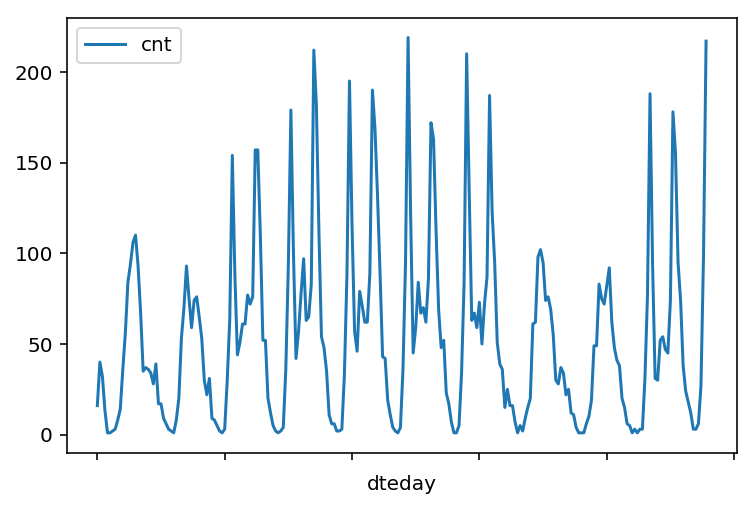

In [66]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables

이제 우리가 만들어야 하는 모델이 머리속에 그려지시나요?

input data : 시간 (연/월/일/시간/공휴일여부), 기상정보 (날씨,온도,습도,풍속)
output data : # of casual rider, # of registered rider

이제 이러한 변수들을 모델에 포함시켜야겠죠. 이제 'Binary Dummy Variables'가 필요합니다. Pandas의 `get_dummies()` 함수로 간단하게 만들 수 있습니다.

Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [67]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables

이제 데이터셋이 준비되었습니다. 그리고 네트워크 훈련을 쉽게 만들기 위해, 변수들을 standarize 시키겠습니다. 변수들의 범위는 각자 모두 다른데, (예를들어 온도는 대략 0~30도 범위이고, 습도는 0~1 범위겠죠.) standarize를 통해 데이터들을 zero mean을 갖게 하고 표준편차를 1로 만들어줍니다. 이러한 전처리는 네트워크의 훈련을 쉽게 만들어 줍니다. 

scaling factor는 어떻게 구할까요? 고맙게도, 데이터셋에서 함께 제공해주고 있었습니다.

To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [68]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

학습을 위해서는 training, testing 그리고 validation set으로 나누어주어야 합니다.
training set은 학습 후 예상을 만들어 보고 실제 데이터와 비교하는데 쓰입니다.
우리는 다음과 같이 데이터 셋을 나누어 주겠습니다.
(마지막 21일을 하지 않고 랜덤으로 추출한다면?)

* test seting : 21일
* training set : 그 외 모두

그리고 testing set을  다시 두개로 나눕니다. 하나는 training을 위한 test set, 하나는 validation을 위한 set입니다. 이 데이터 셋은 시계열 데이터로써, test셋을 마지막 21일로 설정함으로써 '과거의 데이터를 학습'하고 '미래의 데이터를 예측' 하게 됩니다. 이때 '미래의 데이터'로써 사용되는 것이 'validation set'입니다.

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [69]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

이제 본격적으로 네트워크를 만들어 보겠습니다.

우리는 미래 예측을 위해 forward pass와 backwards pass를 적용할 것입니다. 그리고 hyperparameter로써 learning rate, hidden units의 숫자, training passes의 횟수를 설정합니다. 

<img src="assets/neural_network.png" width=300px>

#### Forward Propagation

네트워크는 총 두 레이어로 구성되어 있습니다. hidden layer와 output 레이어입니다. hidden later는 activation 함수로 sigmoid를 사용합니다. 그리고 output layer는 regression을 위한 단 하나의 node를 가지고 있습니다. output layer에서 출력되는 output은 input과 같습니다. 이 것을 수식으로 표현하자면, activation 함수가 $f(x) = x $가 된다는 말입니다. 참고로 activation 함수란 입력 신호를 받아 출력 신호를 생성하지만 임계값 (threshold)를 고려하는 함수를 말합니다. 우리는 각각 뉴런의 출력을 계산하는 네트워크의 레이어를 따라서 계산합니다. 한 레이어에서 나오는 모든 출력은 다음 네트워크의 입력이 됩니다. 이것을 ``forward propagation`` 이라고 합니다.

#### Back Propagation

우리는 네트워크의 weight를 이용해서 입력에서 출력을 향해 신호를 전달합니다. 그리고 최종 output과 실제 데이터 (ground truth)간의 error를 계산하고, 이 에러를 다시 weight를 이용해 출력단에서 입력단으로 거슬러 계산합니다. 이러한 과정을 ```back propagation``` 이라고 합니다.

#### 구현하기
네트워크를 구현하는 과정은 다음 순서로 진행합니다.
1. sigmoid함수를 정의합니다. sigmoid 함수는 activation 함수로 사용될 겁니다.
2. `train` method에 forward pass 를 구현합니다.
3. error를 계산하는 함수를 정의합니다.
4. `train` method에 back propagation 알고리즘을 구현합니다. 3)에서 정의한 error를 사용해야겠죠.
5. `run` method에 forward pass를 구현합니다.

Below you'll build your network. We've built out the structure. You'll implement both the forward pass and backwards pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [85]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

from my_answers import NeuralNetwork

In [86]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

네트워크를 만들었다면, train에 앞서 오류가 있는지, 무결성 테스트해보겠습니다. train을 하려면 아래 테스트를 성공적으로 통과해야 합니다.

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [87]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

정확도 테스트를 통과했다면, train을 할 준비가 되었습니다! 이제 hyperparameter들을 설정합니다. 이 parameter들을 설정하는 목표는, 네트워크가 overfitting되지 않으면서도 error가 낮도록 해야겠죠. network를 너무 복잡하거나 오랫동안 train한다면 overfitting되기 쉽상입니다. 그렇게 되면 train중에는 에러가 낮게 나오더라도, validation 과정에서 실패한 네트워크가 되버립니다. 따라서 train 중에 validation test를 계속 해주면서, validation test의 loss가 증가하기 시작하는 지점을 포착해야 합니다.

이러한 과정에 `Stochastic Gradient Descent (SGD)` 방법이 도움이 될 수 있습니다. 간단하게 설명하자면, 각각의 training pass동안 전체 데이터셋을 이용해 훈련하는 것이 아닌, 데이터셋 중 랜덤한 일부만 뽑아 학습을 진행합니다. 이 방법은 training pass의 수는 더 많이 필요하게 되겠지만, 각각의 pass는 더 빠르게 진행되고 최종 결과물도 더욱 효율적입니다.

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations

`Stochastic Gradient Descent (SGD)` 방법은 전체 데이터 셋을 몇 개의 부분집합으로 나누어 여러번 학습을 진행한다고 했습니다. 이때 '몇 개의 부분집합으로 나눌 것인가?' 를 결정하는 변수가 `batches`입니다. batch를 높게 설정할 수록 iteration이 많아질 거고, iteration이 많아질 수록 학습된 모델은 데이터에 더 잘 들어맞겠죠. 하지만,, 많다고 좋은게 아닙니다. 너무 batch를 많게 하면 효율에 비해 과도한 컴퓨팅 리소스를 소모하는 낭비로 이어집니다. 그렇다면 적절한 iteration 횟수는 어떻게 설정하는 것이 좋을까요? 우리가 원하는 것은 training loss가 낮고 validation loss가 낮은 네트워크입니다. 따라서 이상적인 iteration 횟수는 validation loss가 더이상 감소하지 않을때까지만 설정하는것이 바람직합니다.

This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.


### Choose the learning rate

learning rate는 weight를 업데이트 해주는 속도를 결정합니다. learning rate가 너무 크면 weight가 과도하게 변하게 되고 결국은 네트워크가 제대로 학습되지 않을 수 있습니다. 반면에 너무 작으면 학습이 느리게 되어 컴퓨팅 리소스를 낭비하거나 local minimum에 빠지게 되겠죠. 그렇다면 어떻게 선택해야 할까요? 보통 0.1정도로 시작합니다. 하지만, learning rate를 n_records로 효과적으로 나눌 수 있다면, 1부터 시작하는 것도 방법입니다. 이때 네트워크가 데이터를 피팅하는데 어려움을 겪는다면 learning rate를 줄여서 다시 학습을 진행해 봅니다. 다양한 시도를 할수록 더 나은 결과를 얻을 수 있을겁니다.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [88]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 16.0% ... Training loss: 0.515 ... Validation loss: 0.753

/home/eungbean/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Progress: 99.0% ... Training loss: 0.290 ... Validation loss: 0.448

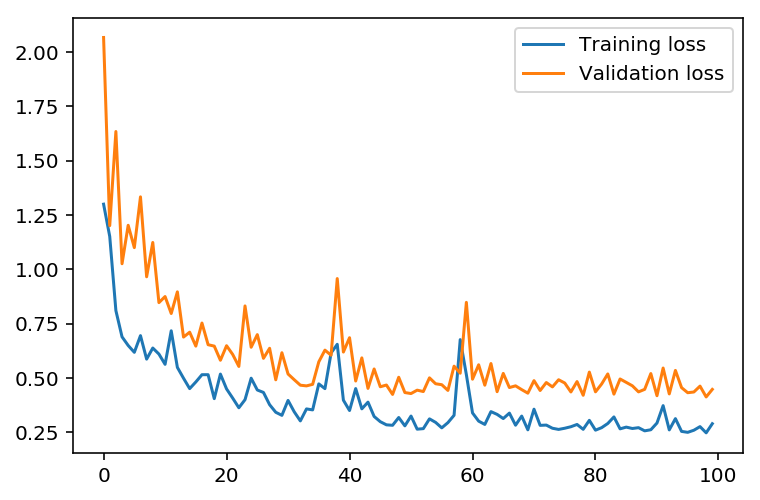

In [89]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

/home/eungbean/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


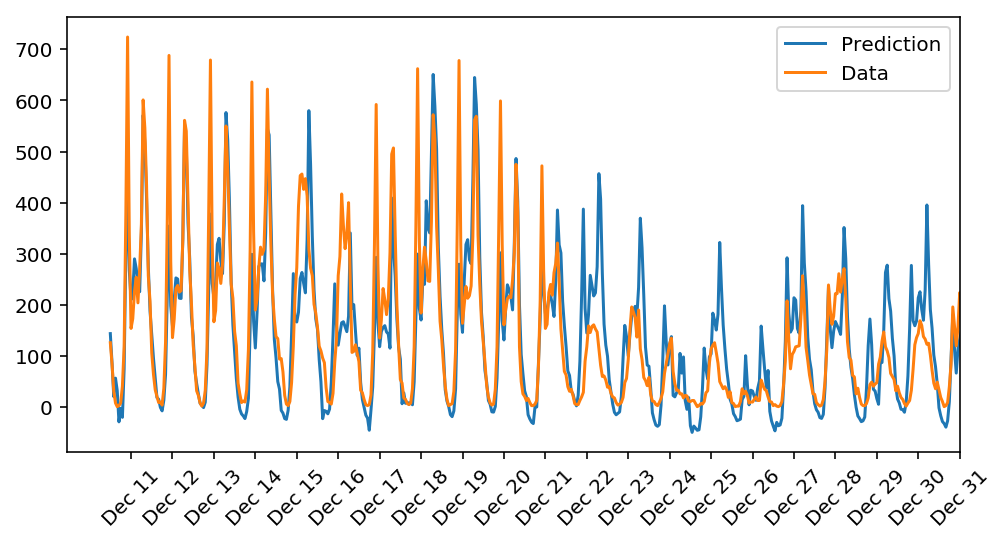

In [90]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

In [91]:
Small mistakes, Whole network broken.

SyntaxError: invalid syntax (<ipython-input-91-be39d3982b6a>, line 1)